In [1]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error


import matplotlib.pyplot as plt
import seaborn as sns

#  Loading Data
SET runonGoogleDrive TRUE if notebook is running on Google Drive

In [2]:
runonGoogleDrive = True

if runonGoogleDrive:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading Data
if runonGoogleDrive:
  train = pd.read_csv('/content/drive/MyDrive/Advanced_Topics_Project/Data/dengue_features_train.csv')
  test = pd.read_csv('/content/drive/MyDrive/Advanced_Topics_Project/Data/dengue_features_test.csv')
  train_labels = pd.read_csv('/content/drive/MyDrive/Advanced_Topics_Project/Data/dengue_labels_train.csv')
  submission_format = pd.read_csv('/content/drive/MyDrive/Advanced_Topics_Project/Data/submission_format.csv')
  train_df = pd.read_csv('/content/drive/MyDrive/Advanced_Topics_Project/Data/final_training.csv')
  taiwan_df = pd.read_csv('/content/drive/MyDrive/Advanced_Topics_Project/Data/final_taiwan.csv')
else:
  train = pd.read_csv('dengue_features_train.csv')
  test = pd.read_csv('dengue_features_test.csv')
  train_labels = pd.read_csv('dengue_labels_train.csv')
  submission_format = pd.read_csv('submission_format.csv')
  train_df = pd.read_csv('final_training.csv')
  taiwan_df = pd.read_csv('final_taiwan.csv')

# Cleaning the Data
Getting Correlation Matrix and PCA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

In [5]:
# City: San Juan = 0, Iquitos = 1
train['city'] = train['city'].replace(['sj', 'iq'], [0, 1])

# Converting week_start_date to datetime
train['week_start_date'] = pd.to_datetime(train['week_start_date'])

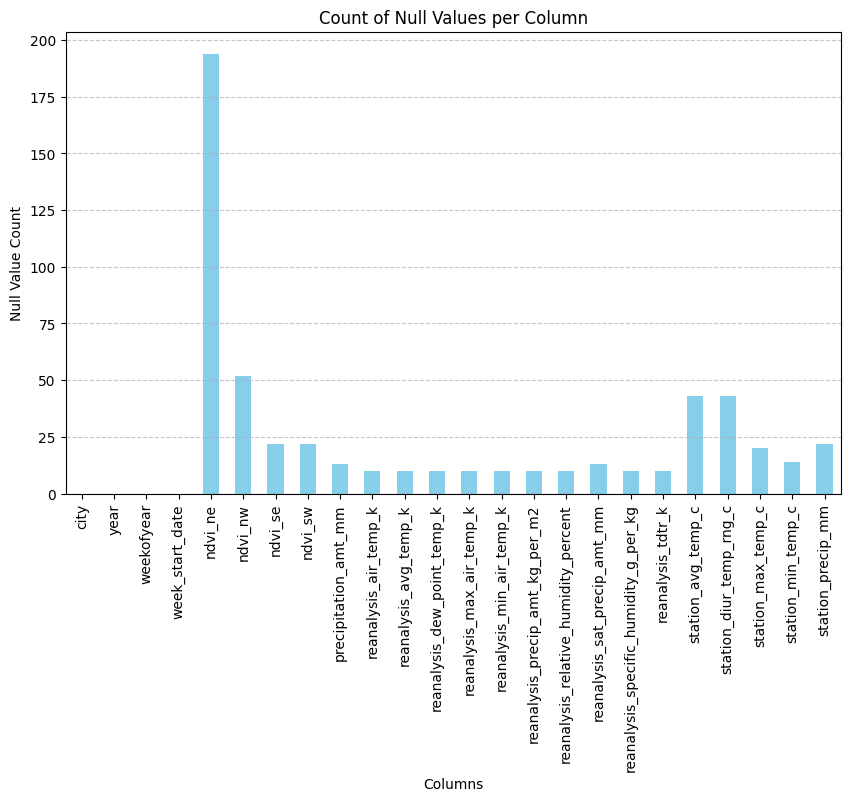

In [6]:
# Null Analysis

null_counts = train.isnull().sum()
plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Null Values per Column')
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Top Correlated Pairs:
                        Column 1                               Column 2  \
140         precipitation_amt_mm           reanalysis_sat_precip_amt_mm   
180  reanalysis_dew_point_temp_k  reanalysis_specific_humidity_g_per_kg   
192    reanalysis_max_air_temp_k                      reanalysis_tdtr_k   
16                          city                      reanalysis_tdtr_k   
148        reanalysis_air_temp_k                  reanalysis_avg_temp_k   
239            reanalysis_tdtr_k                station_diur_temp_rng_c   
63                       ndvi_ne                                ndvi_nw   
18                          city                station_diur_temp_rng_c   
10                          city              reanalysis_max_air_temp_k   
194    reanalysis_max_air_temp_k                station_diur_temp_rng_c   
100                      ndvi_se                                ndvi_sw   
244           station_avg_temp_c                     station_max_temp_c   

  

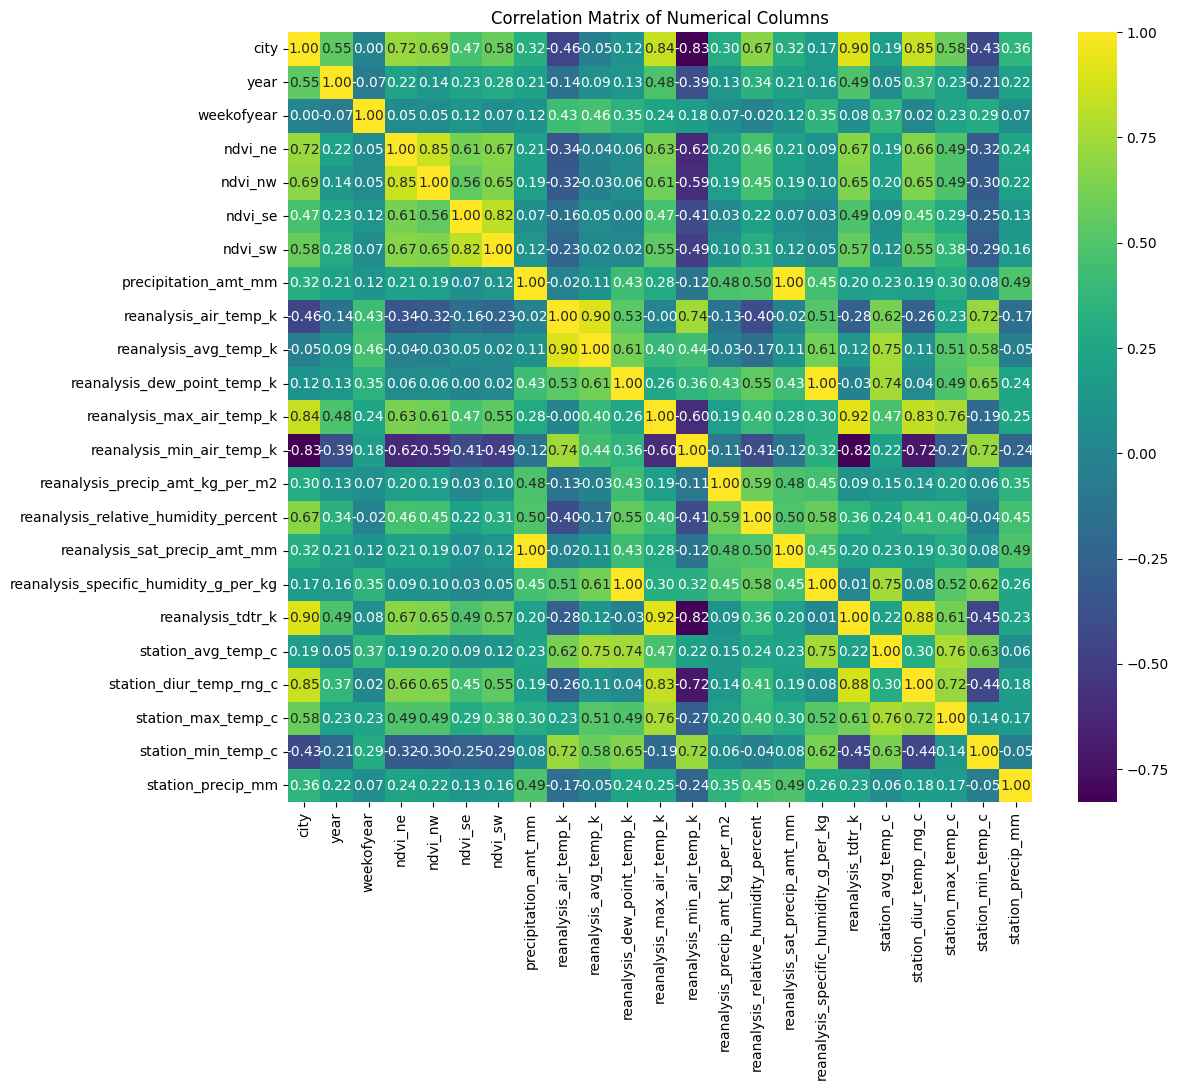

In [7]:
# Coorelation Analysis | Top 12 most coorelated column pairs

numerical_columns = train.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_columns.corr()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

correlation_pairs = upper_triangle.stack().reset_index()
correlation_pairs.columns = ['Column 1', 'Column 2', 'Correlation']
sorted_correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

n = 12
top_correlated_pairs = sorted_correlation_pairs.head(n)
print("Top Correlated Pairs:")
print(top_correlated_pairs)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

In [8]:
# Dropping ndvi columns + Adding Label

# Concatenate horizontally
df_cleaned = pd.concat([train, train_labels], axis=1)

df_cleaned = df_cleaned.drop(columns=['ndvi_se', 'ndvi_sw', 'ndvi_ne', 'ndvi_nw', 'week_start_date', 'city'])

# Drop rows with NaNs
df_cleaned = df_cleaned.dropna()

# Standardizing data
column_means = np.mean(df_cleaned, axis=0)
centered_data = df_cleaned - column_means

df_cleaned.shape

(1400, 21)

Corresponding Original Columns:
Principal Component 1 is most influenced by column: year
Principal Component 2 is most influenced by column: weekofyear
Principal Component 3 is most influenced by column: precipitation_amt_mm
Principal Component 4 is most influenced by column: reanalysis_air_temp_k
Principal Component 5 is most influenced by column: reanalysis_avg_temp_k
Principal Component 6 is most influenced by column: reanalysis_dew_point_temp_k
Principal Component 7 is most influenced by column: reanalysis_max_air_temp_k
Principal Component 8 is most influenced by column: reanalysis_min_air_temp_k
Principal Component 9 is most influenced by column: reanalysis_precip_amt_kg_per_m2
Principal Component 10 is most influenced by column: reanalysis_relative_humidity_percent
Principal Component 11 is most influenced by column: reanalysis_sat_precip_amt_mm
Principal Component 12 is most influenced by column: reanalysis_specific_humidity_g_per_kg
Principal Component 13 is most influenced by

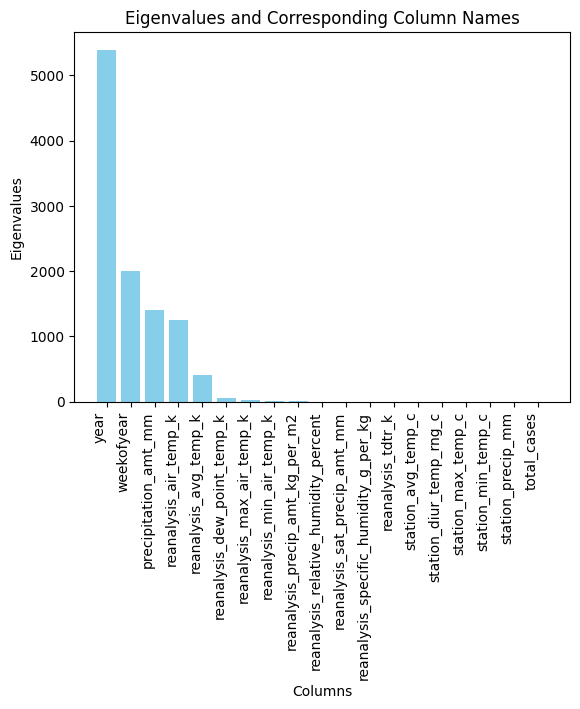

In [9]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_cleaned)

explained_variance = pca.explained_variance_
eigen_vectors = pca.components_
col_names = df_cleaned.columns

sorted_index = np.argsort(explained_variance)[::-1]
sorted_eigenvalue = explained_variance[sorted_index]
sorted_eigenvectors = eigen_vectors[sorted_index, :]
principal_components = sorted_eigenvectors[:, :]

# Showing which columns they correspond to
print('Corresponding Original Columns:')
for i, idx in enumerate(sorted_index[:]):
    print(f"Principal Component {i + 1} is most influenced by column: {col_names[idx]}")

# Plotting to see actual eigenvals
plt.bar(col_names[sorted_index], sorted_eigenvalue, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues and Corresponding Column Names')
plt.xticks(rotation = 90, ha = 'right')
plt.show()

In [10]:
# Checking explained variance with the top 8 components
pca_check = PCA(n_components=8)
pca_check.fit(df_cleaned)

print(pca_check.explained_variance_ratio_)
print(pca_check.explained_variance_ratio_.cumsum())

[0.50989793 0.18877686 0.13269715 0.11881545 0.03887014 0.00572984
 0.00254824 0.00153896]
[0.50989793 0.69867479 0.83137194 0.95018739 0.98905753 0.99478737
 0.99733561 0.99887457]


# Baseline Models

In [11]:
x_taiwan = taiwan_df.drop(columns=['total_cases'])
y_taiwan = taiwan_df['total_cases']

In [12]:
train_df

,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_relative_humidity_percent,total_cases
0,12.42,297.572857,297.742857,292.414286,299.8,295.9,73.365714,4
1,22.82,298.211429,298.442857,293.951429,300.9,296.4,77.368571,5
2,34.54,298.781429,298.878571,295.434286,300.5,297.3,82.052857,4
3,15.36,298.987143,299.228571,295.310000,301.4,297.0,80.337143,3
4,7.52,299.518571,299.664286,295.821429,301.9,297.5,80.460000,6
...,...,...,...,...,...,...,...,...
1395,55.30,299.334286,300.771429,296.825714,309.7,294.5,88.765714,5
1396,86.47,298.330000,299.392857,296.452857,308.5,291.9,91.600000,8
1397,58.94,296.598571,297.592857,295.501429,305.5,292.4,94.280000,1
1398,59.67,296.345714,297.521429,295.324286,306.1,291.9,94.660000,1


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X = train_df.drop(columns=['total_cases'])
y = train_df['total_cases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
#Linear Regressions

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

linear_reg = LinearRegression()
lasso_reg = Lasso(alpha=0.1)

linear_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

linear_reg_predictions = linear_reg.predict(X_test)
lasso_reg_predictions = lasso_reg.predict(X_test)
linear_reg_rmse = mean_squared_error(y_test, linear_reg_predictions, squared=False)
lasso_reg_rmse = mean_squared_error(y_test, lasso_reg_predictions, squared=False)

linear_reg_medae = median_absolute_error(y_test, linear_reg_predictions)
lasso_reg_medae = median_absolute_error(y_test, lasso_reg_predictions)

linear_reg_mae = mean_absolute_error(y_test, linear_reg_predictions)
lasso_reg_mae = mean_absolute_error(y_test, lasso_reg_predictions)

print("Linear Regression RMSE:", linear_reg_rmse)
print("Lasso Regression RMSE:", lasso_reg_rmse)
print("Linear Regression Median Absolute Error:", linear_reg_medae)
print("Lasso Regression Median Absolute Error:", lasso_reg_medae)
print("Linear Regression Mean Absolute Error:", linear_reg_mae)
print("Lasso Regression Mean Absolute Error:", lasso_reg_mae)

linear_reg_r2 = linear_reg.score(X_test, y_test)
lasso_reg_r2 = lasso_reg.score(X_test, y_test)

print("Linear Regression R-squared:", linear_reg_r2)
print("Lasso Regression R-squared:", lasso_reg_r2)

Linear Regression RMSE: 41.67266052802542
Lasso Regression RMSE: 41.79305450471505
Linear Regression Median Absolute Error: 13.259441898026921
Lasso Regression Median Absolute Error: 12.956390486759346
Linear Regression Mean Absolute Error: 21.787219181955347
Lasso Regression Mean Absolute Error: 21.84958565992232
Linear Regression R-squared: 0.12344242939866501
Lasso Regression R-squared: 0.11837029367116192


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.372e+02, tolerance: 2.175e+02
  model = cd_fast.enet_coordinate_descent(


In [15]:
# Random Forrest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

random_forest_reg = RandomForestRegressor(random_state=42)
random_forest_reg.fit(X_train, y_train)

random_forest_predictions = random_forest_reg.predict(X_test)
random_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)
random_forest_medae = median_absolute_error(y_test, random_forest_predictions)
random_forest_mae = mean_absolute_error(y_test, random_forest_predictions)

print("Random Forest RMSE:", random_forest_rmse)
print("Random Forest Median Absolute Error:", random_forest_medae)
print("Random Forest Mean Absolute Error:", random_forest_mae)


Random Forest RMSE: 42.50752907679163
Random Forest Median Absolute Error: 10.920000000000002
Random Forest Mean Absolute Error: 21.657178571428574


In [16]:
# Optimized Random Forest | Grid Search
'''

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(random_forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_random_forest_reg = grid_search.best_estimator_
random_forest_predictions = best_random_forest_reg.predict(X_test)
random_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)
print("Random Forest RMSE:", random_forest_rmse)
print("Best Parameters:", grid_search.best_params_)
'''


'\n\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    \'n_estimators\': [100, 200],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\', \'log2\']\n}\n\nrandom_forest_reg = RandomForestRegressor(random_state=42)\n\ngrid_search = GridSearchCV(random_forest_reg, param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\ngrid_search.fit(X_train, y_train)\n\nbest_random_forest_reg = grid_search.best_estimator_\nrandom_forest_predictions = best_random_forest_reg.predict(X_test)\nrandom_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)\nprint("Random Forest RMSE:", random_forest_rmse)\nprint("Best Parameters:", grid_search.best_params_)\n'

In [17]:
## Tuned Random Forrest

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error


params = {'max_depth': 20,
          'max_features': 'sqrt',
          'min_samples_leaf': 4,
          'min_samples_split': 10,
          'n_estimators': 200}

random_forest_reg = RandomForestRegressor(**params, random_state=42)
random_forest_reg.fit(X_train, y_train)
random_forest_predictions = random_forest_reg.predict(X_test)
random_forest_rmse = mean_squared_error(y_test, random_forest_predictions, squared=False)
random_forest_medae = median_absolute_error(y_test, random_forest_predictions)
random_forest_mae = mean_absolute_error(y_test, random_forest_predictions)

print("Random Forest RMSE:", random_forest_rmse)
print("Random Forest Median Absolute Error:", random_forest_medae)
print("Random Forest Mean Absolute Error:", random_forest_mae)






Random Forest RMSE: 41.91442921030285
Random Forest Median Absolute Error: 10.806833099187122
Random Forest Mean Absolute Error: 20.995665392880987


In [18]:
# XG Boost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

xgb_predictions = xgb_reg.predict(X_test)

xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_medae = median_absolute_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print("XGBoost RMSE:", xgb_rmse)
print("XGBoost Median Absolute Error:", xgb_medae)
print("XGBoost Mean Absolute Error:", xgb_mae)

XGBoost RMSE: 45.57812084548913
XGBoost Median Absolute Error: 11.465677738189697
XGBoost Mean Absolute Error: 24.83802501442177


In [19]:
## Grid Search | XG Boost
'''

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.3, 0.5],
    'objective': ['reg:squarederror']
}

xgb_reg = xgb.XGBRegressor(random_state=42)

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

'''

'\n\nfrom sklearn.model_selection import GridSearchCV\nimport xgboost as xgb\n\nparam_grid = {\n    \'max_depth\': [3, 6, 9],\n    \'n_estimators\': [50, 100, 200],\n    \'learning_rate\': [0.1, 0.3, 0.5],\n    \'objective\': [\'reg:squarederror\']\n}\n\nxgb_reg = xgb.XGBRegressor(random_state=42)\n\ngrid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring=\'neg_mean_squared_error\')\n\ngrid_search.fit(X_train, y_train)\n\nprint("Best Parameters:", grid_search.best_params_)\n\n'

In [20]:
# Tuned XG Boost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

best_params = {'learning_rate': 0.1,
               'max_depth': 3,
               'n_estimators': 50,
               'objective': 'reg:squarederror',
               'random_state': 42}

xgb_reg = xgb.XGBRegressor(**best_params)
xgb_reg.fit(X_train, y_train)
xgb_predictions = xgb_reg.predict(X_test)

xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_medae = median_absolute_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print("XGBoost RMSE:", xgb_rmse)
print("XGBoost Median Absolute Error:", xgb_medae)
print("XGBoost Mean Absolute Error:", xgb_mae)

XGBoost RMSE: 42.09930091269642
XGBoost Median Absolute Error: 11.190221786499023
XGBoost Mean Absolute Error: 21.430713594811305


In [21]:
## Neural Network

import tensorflow as tf
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions = model.predict(X_test).flatten()
nn_rmse = mean_squared_error(y_test, nn_predictions, squared=False)
nn_medae = median_absolute_error(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
print("Neural Network RMSE:", nn_rmse)
print("Neural Network Median Absolute Error:", nn_medae)
print("Neural Network Mean Absolute Error:", nn_mae)

9/9 [==============================] - 1s 11ms/step
Neural Network RMSE: 44.17089288955485
Neural Network Median Absolute Error: 20.1885347366333
Neural Network Mean Absolute Error: 24.92311626161848


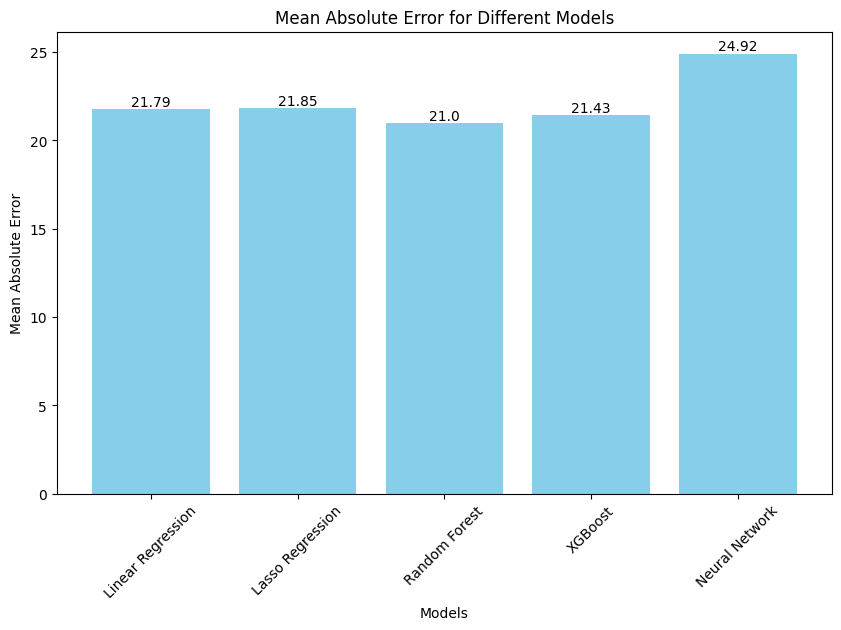

In [22]:
import matplotlib.pyplot as plt

mae_values = [linear_reg_mae, lasso_reg_mae, random_forest_mae, xgb_mae, nn_mae]
models = ['Linear Regression', 'Lasso Regression', 'Random Forest', 'XGBoost', 'Neural Network']
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color='skyblue')
plt.title('Mean Absolute Error for Different Models')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2),
             ha='center', va='bottom')

plt.show()

In [23]:
import pandas as pd

data = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Random Forest', 'XGBoost', 'Neural Network'],
    'MSE': [linear_reg_rmse, lasso_reg_rmse, random_forest_rmse, xgb_rmse, nn_rmse],
    'MedAE': [linear_reg_medae, lasso_reg_medae, random_forest_medae, xgb_medae, nn_medae],
    'MAE': [linear_reg_mae, lasso_reg_mae, random_forest_mae, xgb_mae, nn_mae]
}

df = pd.DataFrame(data)

In [24]:
# Taiwan Testing

linear_reg_predictions = linear_reg.predict(x_taiwan)
lasso_reg_predictions = lasso_reg.predict(x_taiwan)
random_forest_reg_predictions = random_forest_reg.predict(x_taiwan)
xgb_reg_predictions = xgb_reg.predict(x_taiwan)

nn_model_predictions = model.predict(x_taiwan).flatten()

16/16 [==============================] - 0s 6ms/step


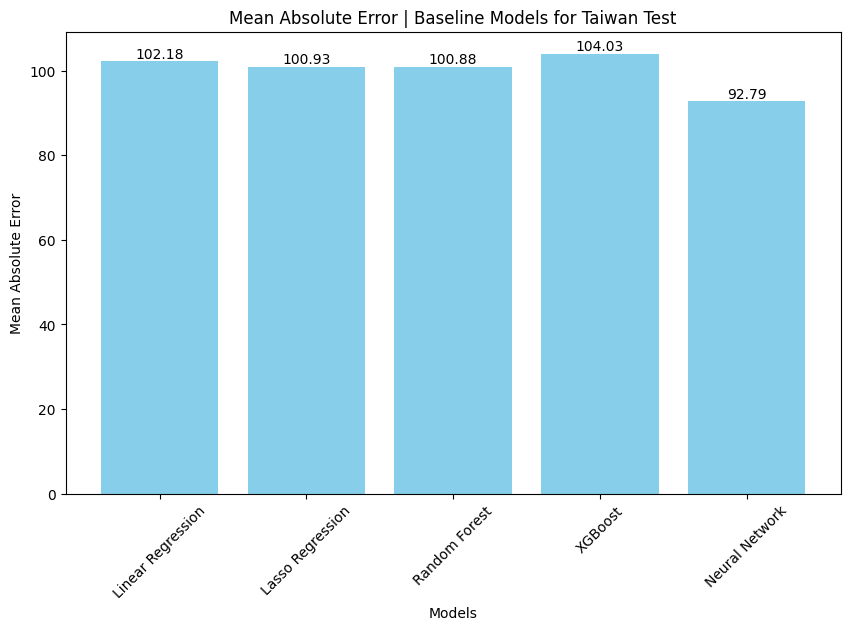

In [25]:
# Taiwant Testing Results

import matplotlib.pyplot as plt
import numpy as np

linear_reg_mae = np.mean(np.abs(linear_reg_predictions - y_taiwan))
lasso_reg_mae = np.mean(np.abs(lasso_reg_predictions - y_taiwan))
random_forest_reg_mae = np.mean(np.abs(random_forest_reg_predictions - y_taiwan))
xgb_reg_mae = np.mean(np.abs(xgb_reg_predictions - y_taiwan))

nn_mae = np.mean(np.abs(nn_model_predictions - y_taiwan))

models = ['Linear Regression', 'Lasso Regression', 'Random Forest', 'XGBoost', 'Neural Network']

mae_values = [linear_reg_mae, lasso_reg_mae, random_forest_reg_mae, xgb_reg_mae, nn_mae]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color='skyblue')
plt.title('Mean Absolute Error | Baseline Models for Taiwan Test')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, round(value, 2), ha='center', va='bottom')

plt.show()



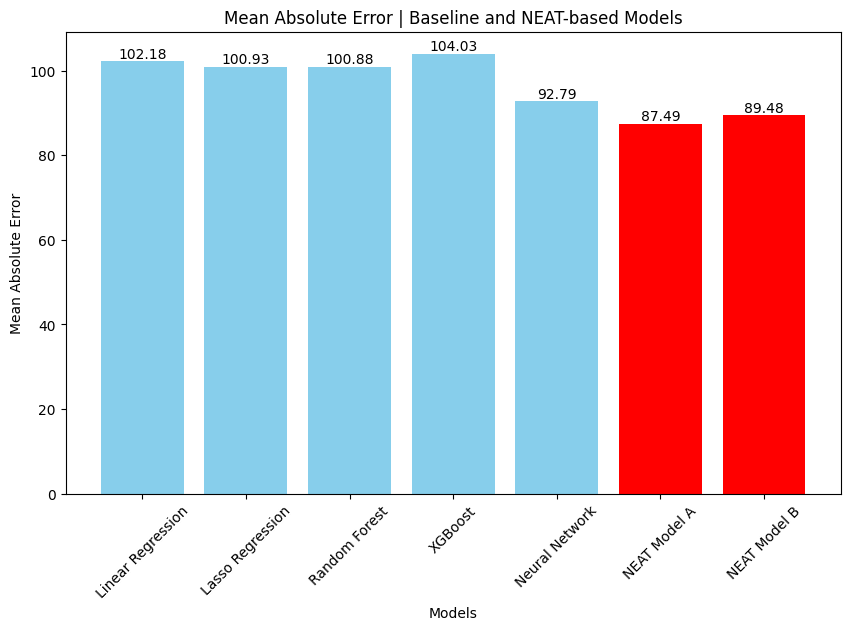

In [26]:
#Inclusion of NEAT here (Result imported from the NEAT notebook)
models = ['Linear Regression', 'Lasso Regression', 'Random Forest', 'XGBoost', 'Neural Network', 'NEAT Model A', 'NEAT Model B']

mae_values = [linear_reg_mae, lasso_reg_mae, random_forest_reg_mae, xgb_reg_mae, nn_mae, 87.49, 89.48]

plt.figure(figsize=(10, 6))
colors = ['skyblue'] * 5 + ['red'] * 2
bars = plt.bar(models, mae_values, color=colors)
plt.title('Mean Absolute Error | Baseline and NEAT-based Models')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

for bar, value in zip(bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, round(value, 2), ha='center', va='bottom')

plt.show()

